In [0]:
%pip install plotly
%pip install torch
%pip install mlflow==1.18.*
%pip install tensorflow-cpu==2.4.*
%pip install tensorflow-probability==0.12.*
%pip install probflow==2.4.*
%pip install seaborn==0.11.*

Python interpreter will be restarted.
Requirement already satisfied: plotly in /databricks/python3/lib/python3.8/site-packages (5.1.0)
Requirement already satisfied: six in /databricks/python3/lib/python3.8/site-packages (from plotly) (1.15.0)
Requirement already satisfied: tenacity>=6.2.0 in /databricks/python3/lib/python3.8/site-packages (from plotly) (8.0.1)
WARNING: You are using pip version 21.0.1; however, version 21.3.1 is available.
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-6b1ac7fc-5ec7-4594-b18b-2bb2b76a9ca5/bin/python -m pip install --upgrade pip' command.
Python interpreter will be restarted.
Python interpreter will be restarted.
Collecting torch
 Downloading torch-1.10.1-cp38-cp38-manylinux1_x86_64.whl (881.9 MB)
Requirement already satisfied: typing-extensions in /databricks/python3/lib/python3.8/site-packages (from torch) (4.0.1)
Installing collected packages: torch
Successfully installed torch-1.10.1
WARNING: You are using pip version 21.0.1; however, version 21.3.1 is available.
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-6b1ac7fc-5ec7-4594-b18b-2bb2b76a9ca5/bin/python -m pip install --upgrade pip' command.
Python interpreter will be restarted.
Python interpreter will be restarted.
Collecting mlflow==1.18.*
 Downloading mlflow-1.18.0-py3-none-any.whl (14.2 MB)
Requirement already satisfied: pytz in /databricks/python3/lib/python3.8/site-packages (from mlflow==1.18.*) (2020.5)
Collecting Flask
 Downloading Flask-2.0.2-py3-none-any.whl (95 kB)
Collecting sqlalchemy
 Downloading SQLAlchemy-1.4.30-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.6 MB)
Requirement already satisfied: pandas in /databricks/python3/lib/python3.8/site-packages (from mlflow==1.18.*) (1.2.4)
Collecting sqlparse>=0.3.1
 Downloading sqlparse-0.4.2-py3-none-any.whl (42 kB)
Requirement already satisfied: gitpython>=2.1.0 in /databricks/python3/lib/python3.8/site-packages (from mlflow==1.18.*) (3.1.26)
Collecting alembic<=1.4.1
 Downloading alembic-1.4.1.tar.gz (1.1 MB)
Requirement already satisfied: numpy in /databricks/python3/lib/python3.8/site-packages (from mlflow==1.18.*) (1.19.2)
Collecting databricks-cli>=0.8.7
 Downloading databricks-cli-0.16.2.tar.gz (58 kB)
Requirement already satisfied: protobuf>=3.7.0 in /databricks/python3/lib/python3.8/site-packages (from mlflow==1.18.*) (3.17.2)
Requirement already satisfied: requests>=2.17.3 in /databricks/python3/lib/python3.8/site-packages (from mlflow==1.18.*) (2.25.1)
Requirement already satisfied: cloudpickle in /databricks/python3/lib/python3.8/site-packages (from mlflow==1.18.*) (2.0.0)
Collecting click>=7.0
 Downloading click-8.0.3-py3-none-any.whl (97 kB)
Collecting gunicorn
 Downloading gunicorn-20.1.0-py3-none-any.whl (79 kB)
Collecting docker>=4.0.0
 Downloading docker-5.0.3-py2.py3-none-any.whl (146 kB)
Collecting querystring-parser
 Downloading querystring_parser-1.2.4-py2.py3-none-any.whl (7.9 kB)
Requirement already satisfied: pyyaml>=5.1 in /databricks/python3/lib/python3.8/site-packages (from mlflow==1.18.*) (6.0)
Requirement already satisfied: packaging in /databricks/python3/lib/python3.8/site-packages (from mlflow==1.18.*) (21.3)
Requirement already satisfied: entrypoints in /databricks/python3/lib/python3.8/site-packages (from mlflow==1.18.*) (0.3)
Collecting prometheus-flask-exporter
 Downloading prometheus_flask_exporter-0.18.7-py3-none-any.whl (17 kB)
Collecting Mako
 Downloading Mako-1.1.6-py2.py3-none-any.whl (75 kB)
Collecting python-editor>=0.3
 Downloading python_editor-1.0.4-py3-none-any.whl (4.9 kB)
Requirement already satisfied: python-dateutil in /databricks/python3/lib/python3.8/site-packages (from alembic<=1.4.1->mlflow==1.18.*) (2.8.1)
Collecting tabulate>=0.7.7
 Downloading tabulate-0.8.9-py3-none-any.whl (25 kB)
Requirement already satisfied: six>=1.10.0 in /databricks/python3/lib/python3.8/site-packages (from databricks-cli>=0.

In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import probflow as pf
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
#import tensorflow as tf
import probflow.utils.ops as O
import torch

In [0]:
pf.set_backend('pytorch')
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
pf.set_datatype(torch.float32)

In [0]:
class NeuralFullBayesianVar(pf.ContinuousModel):

    def __init__(self, units, head_units, damping = 1):
        self.core = pf.DenseNetwork(units,probabilistic = True)
        self.mean = pf.DenseNetwork(head_units)
        self.std  = pf.DenseNetwork(head_units)
        self.damping = damping

    def __call__(self, x):
        z = O.relu(self.core(x))
        loc = self.mean(z)
        cov = torch.diag_embed(O.sqrt(O.softplus(self.damping * self.std(z))))
        return pf.MultivariateNormal(loc, cov)

In [0]:
INITIAL_LEARNING_RATE = 1e-6 
DELTA_LEARNING_RATE = 1e-5
no_layers = 100

In [0]:
data_path = '/dbfs/FileStore/asset_life/v112_neustadt_dosse_10min.csv'
from sklearn.preprocessing import StandardScaler,MinMaxScaler,MaxAbsScaler,RobustScaler

filtered = pd.read_csv(data_path)

#Specify the selected and the required feature
X_headers = ["BladeLoadA_mean","BladeLoadB_mean","BladeLoadC_mean","WindSpeed_mean",
            "RotorSpeed_mean","GeneratorSpeed_mean",
            "PowerActive_mean","NacelleAccX_sd","NacelleAccY_sd",
            "BladeLoadA_max","BladeLoadB_max","BladeLoadC_max","WindSpeed_max","RotorSpeed_mean",
            "GeneratorSpeed_max",
            "PowerActive_max","NacelleAccX_max","NacelleAccY_max"]

Y_headers =["MYTB_del_m4","MZTB_del_m4","MYTM_del_m4","MZTM_del_m4","MYTT_del_m4","MZTT_del_m4"]
x_data = filtered[X_headers].to_numpy(dtype = np.float32)
y_data = filtered[Y_headers].to_numpy(dtype = np.float32)
x_scaler = StandardScaler()
y_scaler = StandardScaler()
X_norm = x_scaler.fit_transform(x_data)
Y_norm = y_scaler.fit_transform(y_data)

X_train, X_pd_test, Y_train, Y_pd_test = train_test_split(X_norm, Y_norm,test_size=0.4,shuffle=True)

In [0]:
# filtered.head(5)

In [0]:
#Splitting dataset for validation and testing

X_val,X_test,Y_val,Y_test = train_test_split(X_pd_test, Y_pd_test,test_size=0.8,shuffle=True)

In [0]:
X_shape = X_train.shape[-1]
Y_shape = Y_train.shape[-1]

topology_core = [no_layers for i in range(3)]
topology_core = [X_shape] + topology_core
topology_output = [no_layers for i in range(3)]
topology_output.append(Y_shape)

In [0]:
param = pf.MultivariateNormalParameter(d=Y_shape)

In [0]:
Model = NeuralFullBayesianVar(topology_core, topology_output, damping = 1)

bnn_mae = pf.MonitorMetric('mae',X_val, Y_val,verbose = True)
bnn_mse = pf.MonitorMetric('mse',X_val, Y_val,verbose = True)
bnn_r2 = pf.MonitorMetric('r2',X_val, Y_val,verbose = True)
monitor_elbo = pf.MonitorELBO(verbose = True)

early_stopping = pf.EarlyStopping(bnn_mse,patience=120)

bnn_lrs = pf.LearningRateScheduler(lambda e: INITIAL_LEARNING_RATE + 
    e * DELTA_LEARNING_RATE, verbose = True)

kl_scheduler = pf.KLWeightScheduler(lambda e: min(1.0, e/50.0))

Model.fit(X_train,
        Y_train,
        batch_size=100,
        epochs=100,
        n_mc=5,
        callbacks=[monitor_elbo, bnn_mae, bnn_lrs, kl_scheduler,bnn_mse,bnn_r2,early_stopping],
        eager=True, shuffle = True
        )

Epoch 1 - learning rate 1.1000000000000001e-05
Epoch 1 ELBO: 4386.840641975403
Epoch 1 mae: 0.7654491662979126
Epoch 1 mse: 0.9846038222312927
Epoch 1 r2: 0.04276520013809204
Epoch 2 - learning rate 2.1000000000000002e-05
Epoch 2 ELBO: 3889.178610801697
Epoch 2 mae: 0.538546085357666
Epoch 2 mse: 0.48670461773872375
Epoch 2 r2: 0.5268243253231049
Epoch 3 - learning rate 3.1e-05
Epoch 3 ELBO: 3325.1768188476562
Epoch 3 mae: 0.31085139513015747
Epoch 3 mse: 0.17324870824813843
Epoch 3 r2: 0.8315670788288116
Epoch 4 - learning rate 4.1e-05
Epoch 4 ELBO: 3209.8575191497803
Epoch 4 mae: 0.2606067955493927
Epoch 4 mse: 0.12578797340393066
Epoch 4 r2: 0.8777085542678833
Epoch 5 - learning rate 5.1e-05
Epoch 5 ELBO: 3256.631447792053
Epoch 5 mae: 0.23598630726337433
Epoch 5 mse: 0.10601586848497391
Epoch 5 r2: 0.8969310522079468
Epoch 6 - learning rate 6.1000000000000005e-05
Epoch 6 ELBO: 3284.5356550216675
Epoch 6 mae: 0.22187043726444244
Epoch 6 mse: 0.09342522919178009
Epoch 6 r2: 0.9091717079281807
Epoch 7 - learning rate 7.1e-05
Epoch 7 ELBO: 3347.9021787643433
Epoch 7 mae: 0.20678071677684784
Epoch 7 mse: 0.08429417759180069
Epoch 7 r2: 0.9180489480495453
Epoch 8 - learning rate 8.1e-05
Epoch 8 ELBO: 3367.881422996521
Epoch 8 mae: 0.20398323237895966
Epoch 8 mse: 0.07966750115156174
Epoch 8 r2: 0.9225470125675201
Epoch 9 - learning rate 9.1e-05
Epoch 9 ELBO: 3393.6906061172485
Epoch 9 mae: 0.1988004446029663
Epoch 9 mse: 0.07708599418401718
Epoch 9 r2: 0.9250567629933357
Epoch 10 - learning rate 0.000101
Epoch 10 ELBO: 3433.5565242767334
Epoch 10 mae: 0.19165700674057007
Epoch 10 mse: 0.07043009251356125
Epoch 10 r2: 0.9315276518464088
Epoch 11 - learning rate 0.000111
Epoch 11 ELBO: 3474.3278255462646
Epoch 11 mae: 0.17722563445568085
Epoch 11 mse: 0.06159196421504021
Epoch 11 r2: 0.9401201084256172
Epoch 12 - learning rate 0.00012100000000000001
Epoch 12 ELBO: 3507.108593940735
Epoch 12 mae: 0.18858976662158966
Epoch 12 mse: 0.0660511702299118
Epoch 12 r2: 0.9357848539948463
Epoch 13 - learning rate 0.000131
Epoch 13 ELBO: 3522.014810562134
Epoch 13 mae: 0.17439736425876617
Epoch 13 mse: 0.05817973241209984
Epoch 13 r2: 0.9434374868869781
Epoch 14 - learning rate 0.000141
Epoch 14 ELBO: 3559.052508354187
Epoch 14 mae: 0.16993631422519684
Epoch 14 mse: 0.056758951395750046
Epoch 14 r2: 0.9448187798261642
Epoch 15 - learning rate 0.000151
Epoch 15 ELBO: 3578.164671897888
Epoch 15 mae: 0.18539351224899292
Epoch 15 mse: 0.062395259737968445
Epoch 15 r2: 0.939339142292738
Epoch 16 - learning rate 0.000161
Epoch 16 ELBO: 3591.239345550537
Epoch 16 mae: 0.17717833817005157
Epoch 16 mse: 0.05738639459013939
Epoch 16 r2: 0.9442087784409523
Epoch 17 - learning rate 0.000171
Epoch 17 ELBO: 3580.5671739578247
Epoch 17 mae: 0.18204355239868164
Epoch 17 mse: 0.05935639142990112
Epoch 17 r2: 0.9422935359179974
Epoch 18 - learning rate 0.000181
Epoch 18 ELBO: 3611.6281175613403
Epoch 18 mae: 0.1644226759672165
Epoch 18 mse: 0.053521934896707535
Epoch 18 r2: 0.9479658156633377
Epoch 19 - learning rate 0.000191
Epoch 19 ELBO: 3596.147367477417
Epoch 19 mae: 0.16708718240261078
Epoch 19 mse: 0.05268874391913414
Epoch 19 r2: 0.9487758465111256
Epoch 20 - learning rate 0.000201
Epoch 20 ELBO: 3606.563656806946
Epoch 20 mae: 0.16594867408275604
Epoch 20 mse: 0.05385167896747589
Epoch 20 r2: 0.9476452358067036
Epoch 21 - learning rate 0.000211
Epoch 21 ELBO: 3581.187910079956
Epoch 21 mae: 0.16289022564888
Epoch 21 mse: 0.04915287345647812
Epoch 21 r2: 0.952213428914547
Epoch 22 - learning rate 0.000221
Epoch 22 ELBO: 3569.1617460250854
Epoch 22 mae: 0.15747541189193726
Epoch 22 mse: 0.048936497420072556
Epoch 22 r2: 0.9524237923324108
Epoch 23 - learning rate 0.000231
Epoch 23 ELBO: 3545.6447353363037
Epoch 23 mae: 0.1627671867609024
Epoch 23 mse: 0.054191216826438904
Epoch 23 r2: 0.9473151378333569
Epoch 24 - learning rate 0.00024100000000000003
Epoch 24 ELBO: 3537.1383895874023
Epoch 24 mae: 0.15360873937606812
Epoch 24 mse: 0.047033440321683884


In [0]:
# monitor_elbo.plot()

In [0]:
# bnn_mae.plot()

In [0]:
# bnn_mse.plot()

In [0]:
y_pred = Model.predict(X_test)

In [0]:
from sklearn.metrics import r2_score
print(r2_score(Y_test,y_pred))

0.9717966341258929

In [0]:
y_pred =  y_scaler.inverse_transform(y_pred)

X = x_scaler.inverse_transform(X_test)
Y = y_scaler.inverse_transform(Y_test)

In [0]:
results_mxtb,results_mytb = pd.DataFrame(data = y_pred[ :,[0]],columns=["pred"]),pd.DataFrame(data = y_pred[ :,[1]],columns=["pred"])
results_mxtt,results_mytt = pd.DataFrame(data = y_pred[ :,[2]],columns=["pred"]),pd.DataFrame(data = y_pred[ :,[3]],columns=["pred"])
results_mxtb['actual'],results_mytb['actual'] = Y[ :,[0]],Y[ :,[1]]
results_mxtt['actual'],results_mytt['actual'] = Y[ :,[2]],Y[ :,[3]]
results_mxtb['X'],results_mytb['X'],results_mxtt['X'],results_mytt['X'] =X[:,[3]],X[:,[3]],X[:,[3]],X[:,[3]]

In [0]:
lwr, upr = Model.predictive_interval(X_test, ci = 0.95,n=500)


lwr = y_scaler.inverse_transform(lwr)
upr = y_scaler.inverse_transform(upr)

In [0]:
#This function calculates the uncertainity metrics PICP and MPIW 
def cal_PICP_MPIW(test,y_true,no_samples=500,ci=0.95):
    lwr, upr = Model.predictive_interval(test, ci = ci,n=no_samples)
       
       
    lwr = y_scaler.inverse_transform(lwr)
    upr = y_scaler.inverse_transform(upr)


    K_u = upr > y_true
    K_l = lwr < y_true


    PICP = np.mean(K_u * K_l)
    MPIW=np.round(np.mean(upr - lwr),3)
    
    return PICP,MPIW


In [0]:
PICP,MPIW = cal_PICP_MPIW(X_test,Y,no_samples=500,ci=0.75)

In [0]:
print("PICP:" , PICP)
print("MPIW:" , MPIW)

PICP: 0.8000514006682087
MPIW: 2106.925

In [0]:
results_mxtb['lwr'],results_mytb['lwr']= lwr[ :,[0]],lwr[ :,[1]]
results_mxtt['lwr'],results_mytt['lwr'] = lwr[ :,[2]],lwr[ :,[3]]

In [0]:
results_mxtb['upr'],results_mytb['upr']= upr[ :,[0]],upr[ :,[1]]
results_mxtt['upr'],results_mytt['upr'] = upr[ :,[2]],upr[ :,[3]]

In [0]:
mxtb= results_mxtb.sort_values(by='X')
mytb= results_mytb.sort_values(by='X')

mxtt= results_mxtt.sort_values(by='X')
mytt= results_mytt.sort_values(by='X')

In [0]:
def plot_uncertainity(results,ax,title):       
    ax.scatter(results['X'],results['actual'],color = 'blue',label='actual',linewidth=.001)
    ax.scatter(results['X'],results['pred'],color = 'red',label='predicted',linewidth=.001)
    ax.fill_between(results['X'], results['lwr'], results['upr'],label='uncertainity',alpha=0.2)
    ax.set_title('{} - r2 {:.4f}'.format(title,r2_score(results['actual'],results['pred'])))
    ax.set_xlabel('WindSpeed')
    ax.set_ylabel('DEL')
    ax.grid()
    ax.legend();

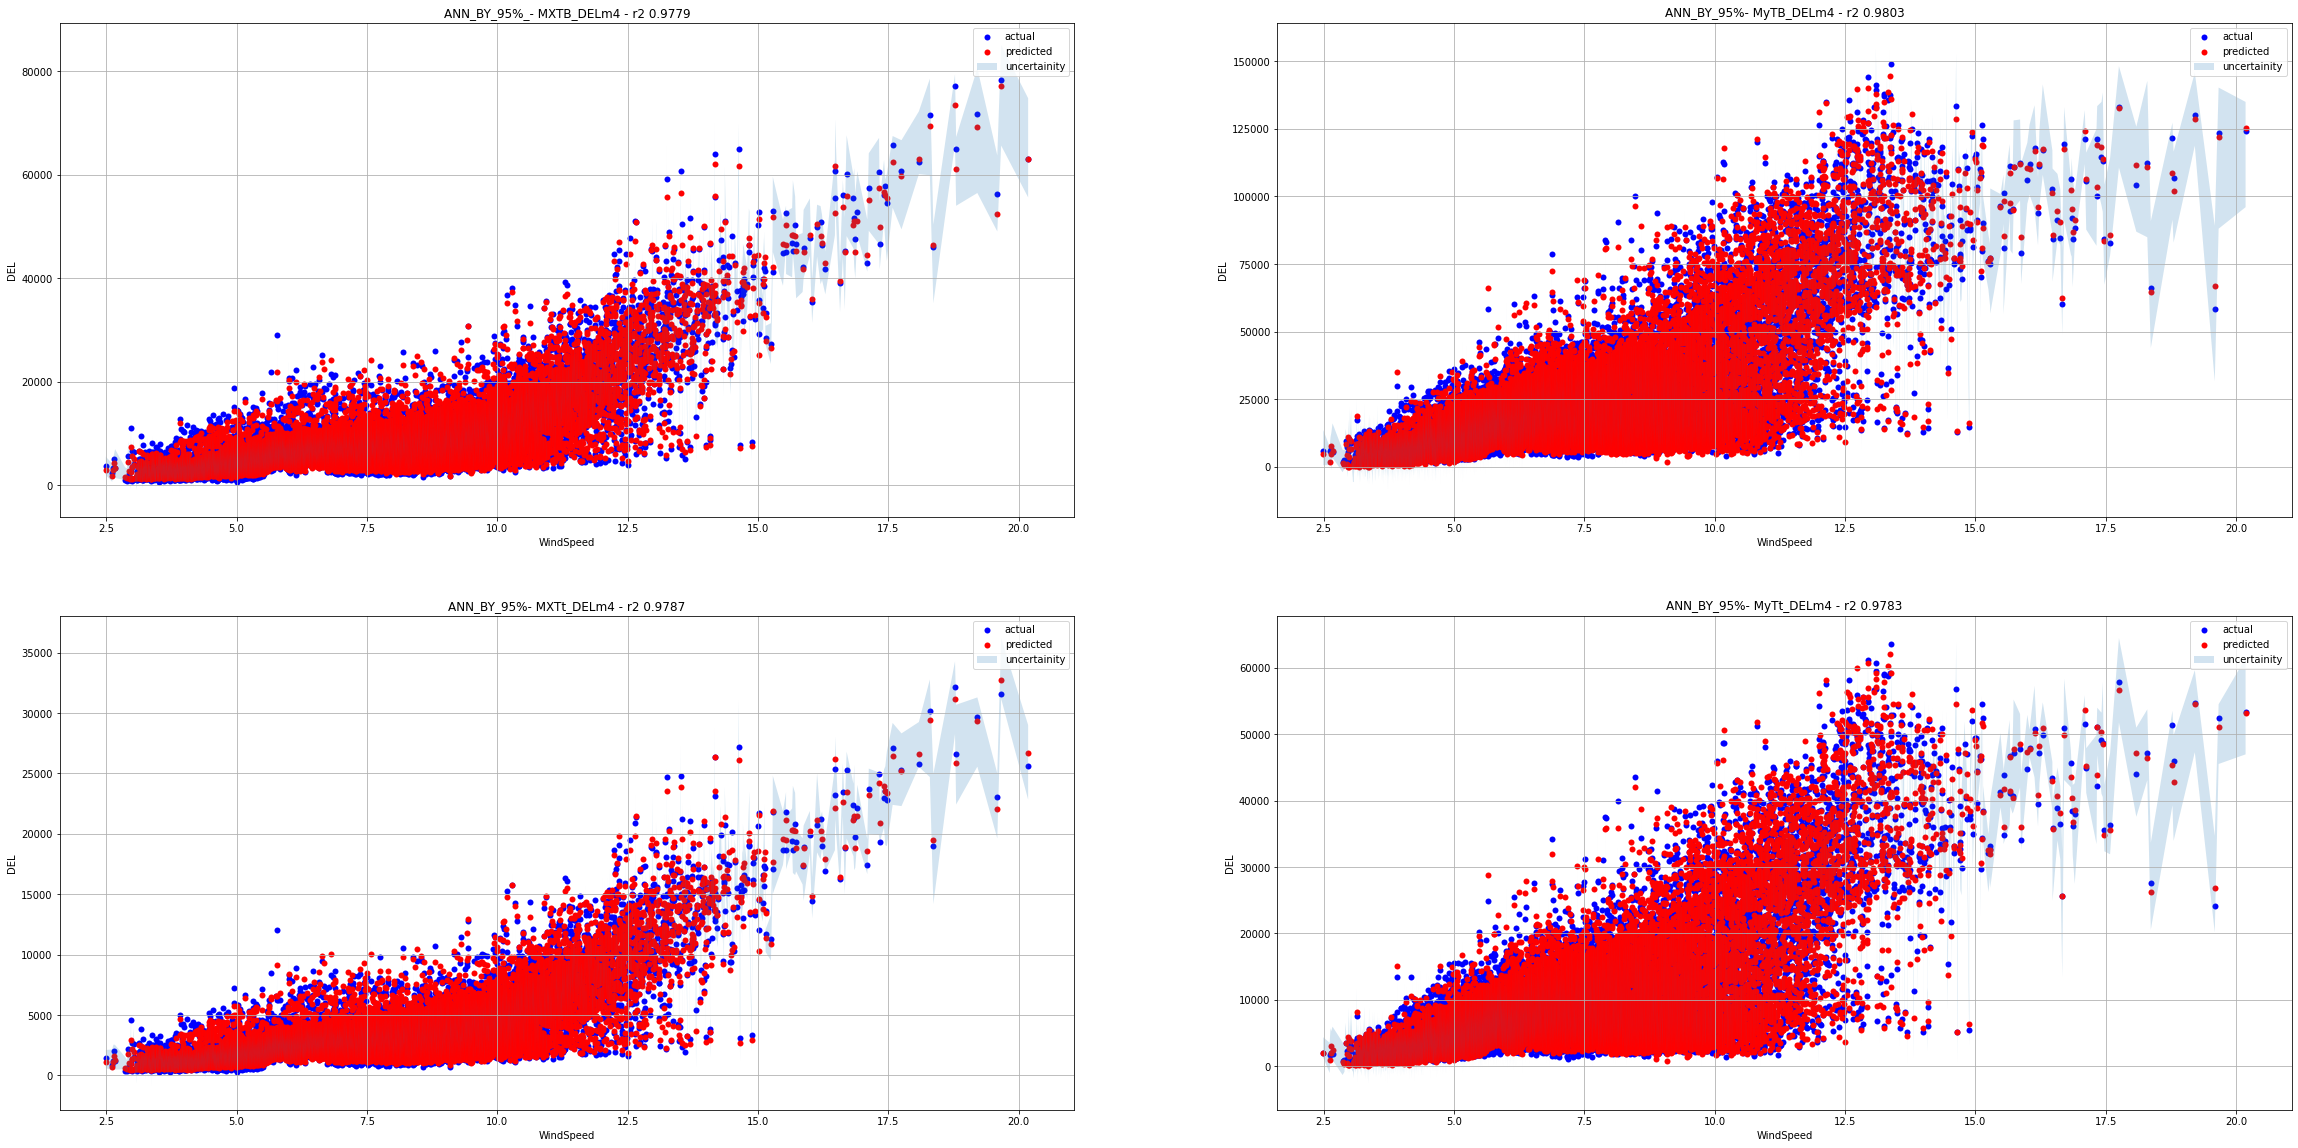

In [0]:
fig, ax = plt.subplots(2,2,figsize=(40,20))

plot_uncertainity(mxtb,ax[0,0],title='ANN_BY_95%_- MXTB_DELm4')
plot_uncertainity(mytb,ax[0,1],title='ANN_BY_95%- MyTB_DELm4')
plot_uncertainity(mxtt,ax[1,0],title='ANN_BY_95%- MXTt_DELm4')
plot_uncertainity(mytt,ax[1,1],title='ANN_BY_95%- MyTt_DELm4')

In [0]:
def woehler_sum(x, m):
    return (np.sum(x**m))**(1/m)

In [0]:
import datetime
now = datetime.datetime.now()
num_samples = 500
samples = Model.predictive_sample(X_test, n=num_samples)
after = datetime.datetime.now()

In [0]:
time = after - now
print(time)

0:00:25.150738

In [0]:
samples = y_scaler.inverse_transform(samples)

In [0]:
accumulated_loads = np.apply_along_axis(woehler_sum,1, samples, m=4)

In [0]:
al_mxtb= [] 
al_mytb=[]
al_mxtt=[]
al_mytt=[]

for x in range(accumulated_loads.shape[0]):
   al_mxtb.append(accumulated_loads[x,0])
   al_mytb.append(accumulated_loads[x,1])
   
   al_mxtt.append(accumulated_loads[x,2])
   al_mytt.append(accumulated_loads[x,3])
    
al_mxtb = np.array(al_mxtb)
al_mytb = np.array( al_mytb)
al_mxtt = np.array(al_mxtt)
al_mytt = np.array(al_mytt)

In [0]:
def plot_loads(samples,measured_load,predicted_load,title):
    ax = sns.boxplot(samples)
    ax.axvline(measured_load, ls='--', c='black',label='actual')
    ax.axvline(predicted_load, ls='-', c='r',label='pred')
    ax.set_title('{} -  {:.4f} deviation=  {:.2f} %'.format(title,measured_load,(((predicted_load - measured_load)/predicted_load)*100)))
    ax.set_xlabel('Accumalated_DEL')
    ax.legend();

In [0]:
ml_mxtb = np.apply_along_axis(woehler_sum,0,mxtb['actual'],m=4) 
ml_mytb = np.apply_along_axis(woehler_sum,0,mytb['actual'],m=4)
ml_mxtt = np.apply_along_axis(woehler_sum,0,mxtt['actual'],m=4)
ml_mytt = np.apply_along_axis(woehler_sum,0,mytt['actual'],m=4)

In [0]:
pd_mxtb = np.apply_along_axis(woehler_sum,0,mxtb['pred'],m=4) 
pd_mytb = np.apply_along_axis(woehler_sum,0,mytb['pred'],m=4)
pd_mxtt = np.apply_along_axis(woehler_sum,0,mxtt['pred'],m=4)
pd_mytt = np.apply_along_axis(woehler_sum,0,mytt['pred'],m=4)

/databricks/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
 warnings.warn(

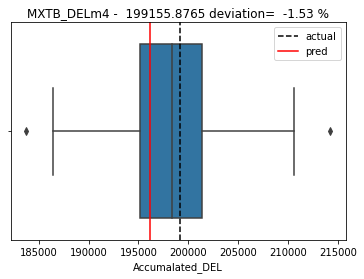

In [0]:
plot_loads(al_mxtb,ml_mxtb,pd_mxtb,title='MXTB_DELm4')

/databricks/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
 warnings.warn(

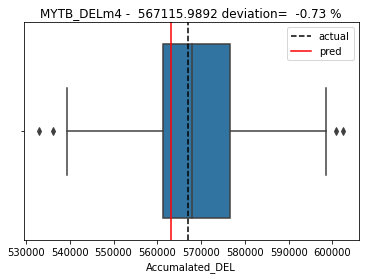

In [0]:
plot_loads(al_mytb,ml_mytb,pd_mytb,title='MYTB_DELm4')

/databricks/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
 warnings.warn(

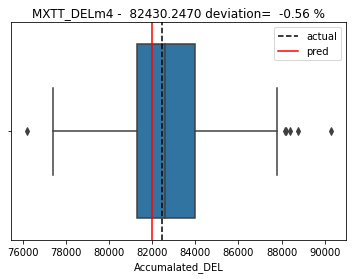

In [0]:
plot_loads(al_mxtt,ml_mxtt,pd_mxtt,title='MXTT_DELm4')

/databricks/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
 warnings.warn(

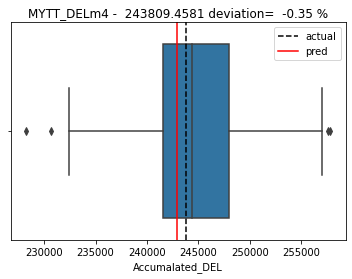

In [0]:
plot_loads(al_mytt,ml_mytt,pd_mytt,title='MYTT_DELm4')

In [0]:
# import mlflow
# mlflow.pyfunc.log_model("models:/asset_life_load_prediction/development")